In [355]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import seaborn as sns
from thefuzz import fuzz, process
from src.scripts import smiles
from src.scripts import targets
from src.utils import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
# Load your JSON file
with open("../data/drug-ndc-0001-of-0001 2.json", "r") as file:
    data = json.load(file)

# Use json_normalize to flatten and load the data into a DataFrame
df = pd.json_normalize(data)
ndc = pd.DataFrame(data["results"]).dropna(
    subset=["generic_name", "brand_name"], how="any"
)

In [328]:
ndc

product_ndc                                generic_name  \
0        72205-211                    lurasidone hydrochloride   
1        72205-249                                  Plerixafor   
2        72205-261                    vilazodone hydrochloride   
3        72205-265                 PHENYLEPHRINE HYDROCHLORIDE   
4        72208-311                              Salicylic Acid   
...            ...                                         ...   
138891   72476-473                                  omeprazole   
138892   72476-623                    cetirizine hydrochloride   
138893   72476-630  dextromethorphan hydrobromide, guaifenesin   
138894   72476-847                  fexofenadine hydrochloride   
138895   72476-875                                  Sennosides   

                                     labeler_name  \
0                     Novadoz Pharmaceuticals LLC   
1                     Novadoz Pharmaceuticals LLC   
2                     Novadoz Pharmaceuticals LLC   
3                     Novadoz Pharmaceuticals LLC   
4                                      Deciem Inc   
...                                           ...   
138891              Retail Business Services, LLC   
138892              Retail Business Services, LLC   
138893              Retail Business Services, LLC   
138894              Retail Business Services, LLC   
138895  Care One (Retail Business Services, LLC.)   

                              brand_name  \
0               lurasidone hydrochloride   
1                             Plerixafor   
2               vilazodone hydrochloride   
3            PHENYLEPHRINE HYDROCHLORIDE   
4       The Ordinary Salicylic Acid 0.5%   
...                                  ...   
138891                careone omeprazole   
138892            careone allergy relief   
138893                 careone tussin dm   
138894            careone allergy relief   
138895                    Senna Laxative   

                                       active_ingredients  finished  \
0       [{'name': 'LURASIDONE HYDROCHLORIDE', 'strengt...      True   
1       [{'name': 'PLERIXAFOR', 'strength': '24 mg/1.2...      True   
2       [{'name': 'VILAZODONE HYDROCHLORIDE', 'strengt...      True   
3       [{'name': 'PHENYLEPHRINE HYDROCHLORIDE', 'stre...      True   
4       [{'name': 'SALICYLIC ACID', 'strength': '5 mg/...      True   
...                                                   ...       ...   
138891    [{'name': 'OMEPRAZOLE', 'strength': '20 mg/1'}]      True   
138892  [{'name': 'CETIRIZINE HYDROCHLORIDE', 'strengt...      True   
138893  [{'name': 'DEXTROMETHORPHAN HYDROBROMIDE', 'st...      True   
138894  [{'name': 'FEXOFENADINE HYDROCHLORIDE', 'stren...      True   
138895   [{'name': 'SENNOSIDES', 'strength': '8.6 mg/1'}]      True   

                                                packaging  \
0       [{'package_ndc': '72205-211-05', 'description'...   
1       [{'package_ndc': '72205-249-01', 'description'...   
2       [{'package_ndc': '72205-261-30', 'description'...   
3       [{'package_ndc': '72205-265-07', 'description'...   
4       [{'package_ndc': '72208-311-01', 'description'...   
...                                                   ...   
138891  [{'package_ndc': '72476-473-01', 'description'...   
138892  [{'package_ndc': '72476-623-63', 'description'...   
138893  [{'package_ndc': '72476-630-26', 'description'...   
138894  [{'package_ndc': '72476-847-22', 'description'...   
138895  [{'package_ndc': '72476-875-10', 'description'...   

       listing_expiration_date  \
0                     20251231   
1                     20251231   
2                     20241231   
3                     20251231   
4                     20251231   
...                        ...   
138891                20251231   
138892                20251231   
138893                20241231   
138894                20251231   
138895                20251231   

                                                  ope

In [329]:
drugbank = pd.read_xml("../data/fulldatabase.xml").dropna(
    subset=["name", "drugbank-id"], how="any"
)

In [330]:
drugbank_ids = pd.read_csv(
    "/Users/guillaumebelissent/Docs/EPFL/MA/ADA/BindingDB_All.tsv",
    sep="\t",
    usecols=["DrugBank ID of Ligand"],
).dropna()

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/3331208598.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  drugbank_ids=pd.read_csv(


In [331]:
dfs = [
    pd.read_csv(
        f"/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/medicaid_{year}.csv"
    )
    for year in range(2000, 2025)
]
medicaid = pd.concat(dfs)
medicaid["Number of Prescriptions"] = medicaid["Number of Prescriptions"].fillna(
    medicaid["No. of Prescriptions"]
)
medicaid["Non-medicaid Amount Reimbursed"] = (
    medicaid["Non-medicaid Amount Reimbursed"]
    .fillna(medicaid["Non-Medicaid Amount Reimbursed"])
    .fillna(medicaid["Non Medicaid Amount Reimbursed"])
)
medicaid = (
    medicaid.dropna(axis=1, how="all")
    .dropna(
        subset=[
            "Units Reimbursed",
            "Number of Prescriptions",
            "Total Amount Reimbursed",
            "Medicaid Amount Reimbursed",
            "Non-medicaid Amount Reimbursed",
        ],
        how="all",
    )
    .drop(
        [
            "No. of Prescriptions",
            "Non-Medicaid Amount Reimbursed",
            "Non Medicaid Amount Reimbursed",
            "State Code",
            "State",
        ],
        axis=1,
    )
)
medicaid["Product Name"] = medicaid["Product Name"].apply(utils.lower)
medicaid.to_csv("full_medicaid.csv")

/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/3410358783.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/medicaid_{year}.csv") for year in range(2000,2025)
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/3410358783.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/medicaid_{year}.csv") for year in range(2000,2025)
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/3410358783.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"/Users/guillaumebelissent/Docs/EPFL/MA/ADA/ada-2024-project-standarddeviants/data/medicaid_{year}.csv") for year in range(2000,2025)
/var/fo

product_ndc                                generic_name  \
0        72205-211                    lurasidone hydrochloride   
1        72205-249                                  plerixafor   
2        72205-261                    vilazodone hydrochloride   
3        72205-265                 phenylephrine hydrochloride   
4        72208-311                              salicylic acid   
...            ...                                         ...   
138891   72476-473                                  omeprazole   
138892   72476-623                    cetirizine hydrochloride   
138893   72476-630  dextromethorphan hydrobromide, guaifenesin   
138894   72476-847                  fexofenadine hydrochloride   
138895   72476-875                                  sennosides   

                                     labeler_name  \
0                     Novadoz Pharmaceuticals LLC   
1                     Novadoz Pharmaceuticals LLC   
2                     Novadoz Pharmaceuticals LLC   
3                     Novadoz Pharmaceuticals LLC   
4                                      Deciem Inc   
...                                           ...   
138891              Retail Business Services, LLC   
138892              Retail Business Services, LLC   
138893              Retail Business Services, LLC   
138894              Retail Business Services, LLC   
138895  Care One (Retail Business Services, LLC.)   

                              brand_name  \
0               lurasidone hydrochloride   
1                             plerixafor   
2               vilazodone hydrochloride   
3            phenylephrine hydrochloride   
4       the ordinary salicylic acid 0.5%   
...                                  ...   
138891                careone omeprazole   
138892            careone allergy relief   
138893                 careone tussin dm   
138894            careone allergy relief   
138895                    senna laxative   

                                       active_ingredients  finished  \
0       [{'name': 'LURASIDONE HYDROCHLORIDE', 'strengt...      True   
1       [{'name': 'PLERIXAFOR', 'strength': '24 mg/1.2...      True   
2       [{'name': 'VILAZODONE HYDROCHLORIDE', 'strengt...      True   
3       [{'name': 'PHENYLEPHRINE HYDROCHLORIDE', 'stre...      True   
4       [{'name': 'SALICYLIC ACID', 'strength': '5 mg/...      True   
...                                                   ...       ...   
138891    [{'name': 'OMEPRAZOLE', 'strength': '20 mg/1'}]      True   
138892  [{'name': 'CETIRIZINE HYDROCHLORIDE', 'strengt...      True   
138893  [{'name': 'DEXTROMETHORPHAN HYDROBROMIDE', 'st...      True   
138894  [{'name': 'FEXOFENADINE HYDROCHLORIDE', 'stren...      True   
138895   [{'name': 'SENNOSIDES', 'strength': '8.6 mg/1'}]      True   

                                                packaging  \
0       [{'package_ndc': '72205-211-05', 'description'...   
1       [{'package_ndc': '72205-249-01', 'description'...   
2       [{'package_ndc': '72205-261-30', 'description'...   
3       [{'package_ndc': '72205-265-07', 'description'...   
4       [{'package_ndc': '72208-311-01', 'description'...   
...                                                   ...   
138891  [{'package_ndc': '72476-473-01', 'description'...   
138892  [{'package_ndc': '72476-623-63', 'description'...   
138893  [{'package_ndc': '72476-630-26', 'description'...   
138894  [{'package_ndc': '72476-847-22', 'description'...   
138895  [{'package_ndc': '72476-875-10', 'description'...   

       listing_expiration_date  \
0                     20251231   
1                     20251231   
2                     20241231   
3                     20251231   
4                     20251231   
...                        ...   
138891                20251231   
138892                20251231   
138893                20241231   
138894                20251231   
138895                20251231   

                                                  ope

In [332]:
drugbank.dropna(subset="name", inplace=True)
ndc.dropna(subset=["brand_name", "generic_name"], inplace=True)
drugbank["name"] = drugbank["name"].apply(utils.lower)
ndc["generic_name"] = ndc["generic_name"].apply(utils.lower)
ndc["brand_name"] = ndc["brand_name"].apply(utils.lower)
drugbank_bdb = pd.merge(
    drugbank,
    drugbank_ids,
    left_on="drugbank-id",
    right_on="DrugBank ID of Ligand",
    how="inner",
)[["name", "drugbank-id", "DrugBank ID of Ligand"]].drop_duplicates()
converter = utils.fuzzy_merge(
    drugbank_bdb,
    ndc[["brand_name", "brand_name_base", "generic_name"]].drop_duplicates(),
    left_on="name",
    right_on="generic_name",
    how="inner",
)
full_prescriptions = (
    medicaid.dropna(subset="Product Name")
    .groupby("Product Name")[
        ["Number of Prescriptions", "Units Reimbursed", "Total Amount Reimbursed"]
    ]
    .apply(sum)
    .reset_index()
)
full_prescriptions["Product Name"] = full_prescriptions["Product Name"].astype(str)
converter["brand_name"] = converter["brand_name"].astype(str)
final = utils.fuzzy_merge(
    converter,
    full_prescriptions,
    left_on="brand_name",
    right_on="Product Name",
    how="inner",
).drop_duplicates()

100%|██████████| 1251/1251 [02:38<00:00,  7.91it/s]
/var/folders/6_/6g10b43x17ngwmk4l9msb2mc0000gn/T/ipykernel_23691/876523432.py:8: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  full_prescriptions = medicaid.dropna(subset='Product Name').groupby('Product Name')[['Number of Prescriptions','Units Reimbursed','Total Amount Reimbursed']].apply(sum).reset_index()
/Users/guillaumebelissent/opt/anaconda3/envs/aada/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
100%|██████████| 3700/3700 [01:40<00:00, 36.92it/s]


In [333]:
full_prescriptions

Product Name  Number of Prescriptions  Units Reimbursed  \
0                               169823762.0      1.835574e+10   
1       #51301 bac                   5698.0      5.919720e+05   
2       ** cloraze                     30.0      1.870000e+03   
3       ** hydroco                   6549.0      2.459550e+05   
4       ** oxazepa                    119.0      7.919000e+03   
...            ...                      ...               ...   
15612   zyvox (lin                   4358.0      1.049484e+07   
15613   zyvox 100m                     27.0      8.400000e+03   
15614   zyvox 600                  634767.0      3.565337e+06   
15615   zyvox iv s                 623458.0      5.125343e+07   
15616   zyvox oral                 116243.0      5.325125e+06   

       Total Amount Reimbursed  
0                 2.056027e+09  
1                 7.309942e+04  
2                 1.337960e+03  
3                 5.649096e+04  
4                 3.047120e+03  
...                        ...  
15612             3.469405e+06  
15613             3.167772e+04  
15614             2.179840e+08  
15615             1.619050e+07  
15616             1.303862e+07  

[15617 rows x 4 columns]

In [336]:
final = final[~(final["brand_name"] == "nan")]

In [337]:
sums = (
    final.dropna(subset=["Number of Prescriptions"])
    .groupby("name")
    .agg(
        {
            "DrugBank ID of Ligand": "first",  # Keep the first (or unique) value of 'DrugBank ID of Ligand'
            "Number of Prescriptions": "sum",  # Sum the numeric columns
            "Units Reimbursed": "sum",
            "Total Amount Reimbursed": "sum",
        }
    )
    .reset_index()
)
sums

name DrugBank ID of Ligand  Number of Prescriptions  \
0               (s)-fluoxetine               DB08544              185129968.0   
1            1-benzylimidazole               DB04581                 188179.0   
2     2,5-dimethoxyamphetamine               DB01465               13120309.0   
3           2-hydroxyquinoline               DB04745                9493704.0   
4    5beta-dihydrotestosterone               DB07447                   8259.0   
..                         ...                   ...                      ...   
280                 vilazodone               DB06684              209338266.0   
281               vildagliptin               DB04876                2253755.0   
282                 viloxazine               DB09185                    195.0   
283                 vismodegib               DB08828                  11123.0   
284               zofenoprilat               DB08766                   7642.0   

     Units Reimbursed  Total Amount Reimbursed  
0        6.046571e+09             3.254190e+09  
1        1.039965e+06             6.081405e+07  
2        4.630275e+08             4.586159e+08  
3        1.706717e+07             1.853166e+07  
4        3.420970e+05             1.701221e+06  
..                ...                      ...  
280      7.124988e+09             2.395436e+09  
281      8.209390e+07             1.144728e+09  
282      9.296000e+03             6.734340e+03  
283      2.973140e+05             1.230787e+08  
284      3.913462e+04             1.184437e+06  

[285 rows x 5 columns]

In [382]:
sums.to_csv("prescription_per_drugbank_id.csv")

In [295]:
import matplotlib.pyplot as plt

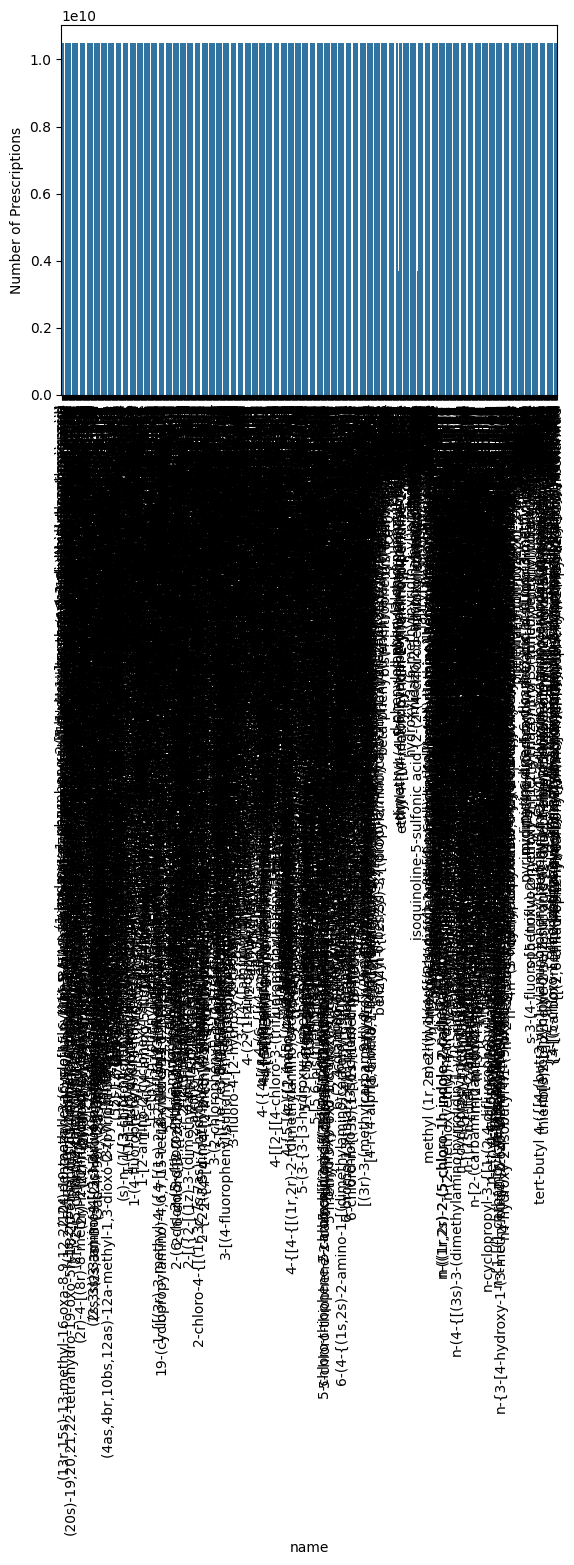

In [298]:
sns.barplot(
    data=sums[sums["Number of Prescriptions"] > 1e10],
    x="name",
    y="Number of Prescriptions",
)
plt.xticks(rotation=90)
# plt.yscale('log')
plt.show()

In [321]:
fuzz.token_sort_ratio("ergometrine", "permethrine")

82

In [339]:
list(ndc.columns)

['product_ndc',
 'generic_name',
 'labeler_name',
 'brand_name',
 'active_ingredients',
 'finished',
 'packaging',
 'listing_expiration_date',
 'openfda',
 'marketing_category',
 'dosage_form',
 'spl_id',
 'product_type',
 'route',
 'marketing_start_date',
 'product_id',
 'application_number',
 'brand_name_base',
 'pharm_class',
 'brand_name_suffix',
 'dea_schedule',
 'marketing_end_date']

In [344]:
ndc["product_ndc"]

0         72205-211
1         72205-249
2         72205-261
3         72205-265
4         72208-311
            ...    
138891    72476-473
138892    72476-623
138893    72476-630
138894    72476-847
138895    72476-875
Name: product_ndc, Length: 118503, dtype: object

In [380]:
ndc["packaging"][0]  # [0]['package_ndc'].split('-')

[{'package_ndc': '72205-211-05',
  'description': '500 TABLET, FILM COATED in 1 BOTTLE (72205-211-05)',
  'marketing_start_date': '20230220',
  'sample': False},
 {'package_ndc': '72205-211-30',
  'description': '30 TABLET, FILM COATED in 1 BOTTLE (72205-211-30)',
  'marketing_start_date': '20230220',
  'sample': False},
 {'package_ndc': '72205-211-90',
  'description': '90 TABLET, FILM COATED in 1 BOTTLE (72205-211-90)',
  'marketing_start_date': '20230220',
  'sample': False}]

In [381]:
get_ndc_list = lambda x: if x[0]['package_ndc'].split('-')
ndc['packaging'].dropna().apply(get_ndc_list)

IndexError: list index out of range

In [340]:
medicaid

Utilization Type          NDC  Labeler Code Product Code Package Size  \
0                  FFSU      2012502             2          125            2   
3                  FFSU      2035102             2          351            2   
4                  FFSU      2035302             2          353            2   
5                  FFSU      2035303             2          353            3   
6                  FFSU      2035333             2          353           33   
...                 ...          ...           ...          ...          ...   
157275             FFSU  99207027675         99207          276           75   
157277             FFSU  99207030030         99207          300           30   
157280             MCOU  99207030060         99207          300           60   
157297             MCOU  99999163999         99999         1639           99   
157302             MCOU  99999930299         99999         9302           99   

        Year  Quarter Suppression Used Product Name  Units Reimbursed  \
0       2000        4            False   a s a                  500.0   
3       2000        4            False   darvocet-n          231219.0   
4       2000        4            False   darvon-n            145562.0   
5       2000        4            False   darvon-n              3769.0   
6       2000        4            False   darvon-n              2628.0   
...      ...      ...              ...          ...               ...   
157275  2024        1            False   zyclara 2.             120.0   
157277  2024        1            False   ziana gel              840.0   
157280  2024        1            False   ziana gel              660.0   
157297  2024        1            False                          144.0   
157302  2024        1            False                         1390.0   

        Number of Prescriptions  Total Amount Reimbursed  \
0                          12.0                     8.96   
3                        5615.0                101752.61   
4                        2387.0                 94752.55   
5                          68.0                  2203.96   
6                          87.0                  1992.36   
...                         ...                      ...   
157275                     13.0                 19602.18   
157277                     22.0                 10322.38   
157280                     11.0                  6799.39   
157297                     40.0                 46296.23   
157302                     15.0                   186.05   

        Medicaid Amount Reimbursed  Non-medicaid Amount Reimbursed Record ID  \
0                             0.00                             0.0       NaN   
3                         22545.09                             0.0       NaN   
4                         10795.56                          1065.0       NaN   
5                             0.00                             0.0       NaN   
6                             0.00                             0.0       NaN   
...                            ...                             ...       ...   
157275                    19602.18                             0.0       NaN   
157277                    10322.38                             0.0       NaN   
157280                     6799.39                             0.0       NaN   
157297                    46296.23                             0.0       NaN   
157302                      186.05                             0.0       NaN   

       Supression Used Product FDA List Name  
0                  NaN                   NaN  
3                  NaN                   NaN  
4                  NaN                   NaN  
5                  NaN                   NaN  
6                  NaN                   NaN  
...                ...                   ...  
157275             NaN                   NaN  
157277             NaN                   NaN  
157280             NaN                   NaN  
157297           

In [ ]:
pd.merge(medicaid)

In [367]:
get_ndc_len = lambda x: len(str(x))
medicaid["NDC"].apply(get_ndc_len).value_counts()

NDC
11    2561609
9      996724
8      303047
7       73113
10       1589
Name: count, dtype: int64

In [363]:
def build_ndc(labeler_code, product_code, package_size):
    if len(str(labeler_code)) == 1:
        labeler_code = str(labeler_code) + "0"

In [364]:
medicaid.apply(build_ndc)

0         FFSU
3         FFSU
4         FFSU
5         FFSU
6         FFSU
          ... 
157275    FFSU
157277    FFSU
157280    MCOU
157297    MCOU
157302    MCOU
Name: Utilization Type, Length: 3936082, dtype: object
0             2012502
3             2035102
4             2035302
5             2035303
6             2035333
             ...     
157275    99207027675
157277    99207030030
157280    99207030060
157297    99999163999
157302    99999930299
Name: NDC, Length: 3936082, dtype: object
0             2
3             2
4             2
5             2
6             2
          ...  
157275    99207
157277    99207
157280    99207
157297    99999
157302    99999
Name: Labeler Code, Length: 3936082, dtype: int64
0          125
3          351
4          353
5          353
6          353
          ... 
157275     276
157277     300
157280     300
157297    1639
157302    9302
Name: Product Code, Length: 3936082, dtype: object
0          2
3          2
4          2
5          3
6 

Utilization Type                  None
NDC                               None
Labeler Code                      None
Product Code                      None
Package Size                      None
Year                              None
Quarter                           None
Suppression Used                  None
Product Name                      None
Units Reimbursed                  None
Number of Prescriptions           None
Total Amount Reimbursed           None
Medicaid Amount Reimbursed        None
Non-medicaid Amount Reimbursed    None
Record ID                         None
Supression Used                   None
Product FDA List Name             None
dtype: object

In [360]:
(
    medicaid["Labeler Code"].astype(str)
    + "0"
    + "-"
    + medicaid["Product Code"].astype(str)
    + "-"
    + medicaid["Package Size"].astype(str)
)

0               2-125-2
3               2-351-2
4               2-353-2
5               2-353-3
6              2-353-33
              ...      
157275     99207-276-75
157277     99207-300-30
157280     99207-300-60
157297    99999-1639-99
157302    99999-9302-99
Length: 3936082, dtype: object